# 🧠 Modul Pembelajaran CNN untuk Klasifikasi Tumor Otak

## 🎯 Tujuan Pembelajaran
Memahami konsep Convolutional Neural Network (CNN) untuk klasifikasi gambar MRI otak, membedakan antara gambar dengan tumor dan tanpa tumor.

In [1]:
# 1. Import Library
from PIL import Image
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
import io
try:
    from google.colab import files
except ImportError:
    files = None  # Atur files=None jika tidak di Colab

## 📦 Persiapan Dataset

### 🔍 Memuat Dataset MRI Otak
- Dataset berisi gambar MRI otak dengan dan tanpa tumor
- Gambar dikategorikan dalam dua kelas: Tumor dan Non-Tumor
- Setiap gambar akan diresize ke 224x224 piksel dan dinormalisasi

In [2]:
import kagglehub
tumor_otak_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')
print('Data source import complete.')

c:\Users\nasyw\OneDrive\Desktop\Infinite_Learning\Tugas_20\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


In [3]:
# 2. Fungsi untuk Load Gambar
def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        img = Image.open(os.path.join(directory, filename))
        img = img.resize((224, 224))
        img = img.convert('RGB')
        img = np.array(img) / 255.0
        images.append(img)
    return images

# Load dataset: otomatis deteksi environment (Colab/Kaggle atau lokal)
try:
    kaggle_path_yes = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes'
    kaggle_path_no = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no'
    if os.path.exists(kaggle_path_yes) and os.path.exists(kaggle_path_no):
        tumor_images = load_images(kaggle_path_yes)
        no_tumor_images = load_images(kaggle_path_no)
    else:
        raise FileNotFoundError
except Exception:
    local_path_yes = 'brain_tumor_dataset/yes'
    local_path_no = 'brain_tumor_dataset/no'
    tumor_images = load_images(local_path_yes)
    no_tumor_images = load_images(local_path_no)

### 🖼️ Visualisasi Data Mentah
- Menampilkan beberapa sampel gambar MRI dengan dan tanpa tumor
- Visualisasi membantu memahami karakteristik data sebelum preprocessing

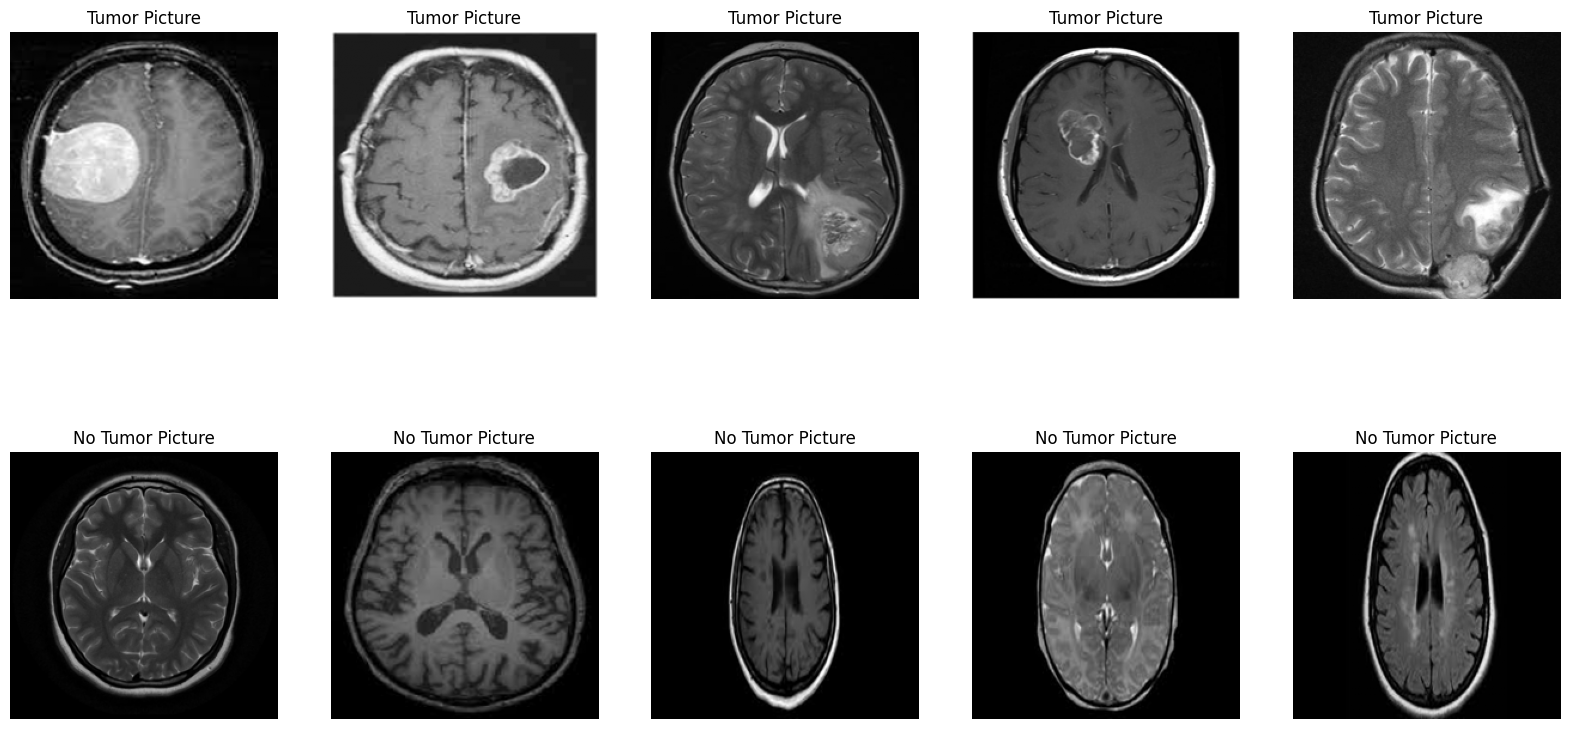

In [4]:
# Visualisasi gambar
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    axes[0, i].imshow(tumor_images[i])
    axes[0, i].set_title('Tumor Picture')
    axes[0, i].axis('off')
for i in range(5):
    axes[1, i].imshow(no_tumor_images[i])
    axes[1, i].set_title('No Tumor Picture')
    axes[1, i].axis('off')
plt.show()

## 🧹 Preprocessing Data

### 🛠️ Normalisasi, Reshaping, dan Labeling
- **Resize**: Semua gambar diubah ke ukuran 224x224 piksel
- **Normalisasi**: Nilai piksel diubah ke rentang 0-1
- **Labeling**: Gambar tumor diberi label 1, non-tumor label 0

In [5]:
def assign_labels(tumor_images, no_tumor_images):
    tumor_labels = np.ones(len(tumor_images))
    no_tumor_labels = np.zeros(len(no_tumor_images))
    return tumor_labels, no_tumor_labels

tumor_labels, no_tumor_labels = assign_labels(tumor_images, no_tumor_images)
data = tumor_images + no_tumor_images
labels = np.concatenate((tumor_labels, no_tumor_labels), axis=0)
X = np.array(data)
y = np.array(labels)

### 🔀 Split Data
- Data dibagi menjadi data latih dan data uji (test set)
- Validasi diambil dari sebagian data latih

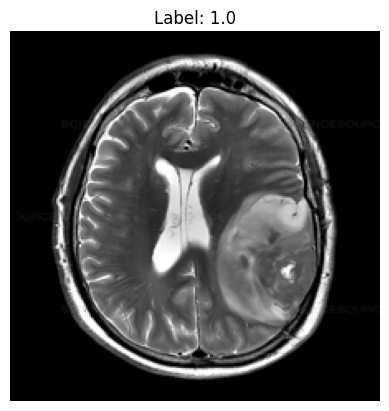

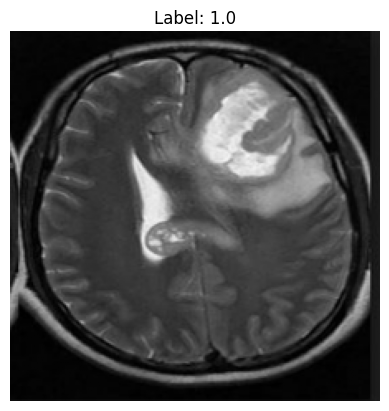

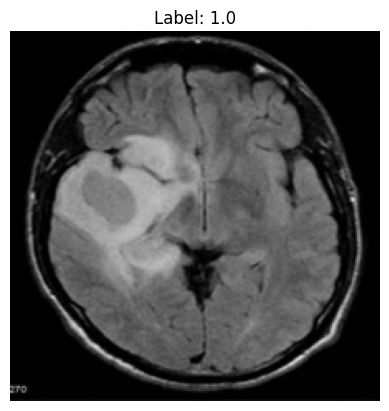

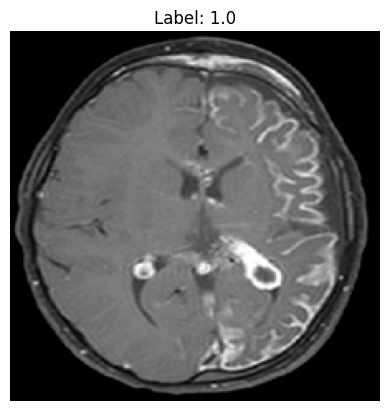

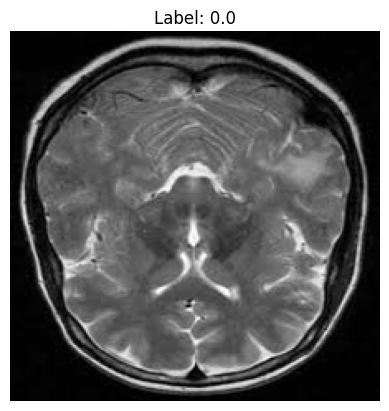

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Visualisasi sampel data latih
for image, label in train.take(5):
    plt.figure()
    plt.imshow(image.numpy())
    plt.title('Label: {}'.format(label.numpy()))
    plt.axis('off')
    plt.show()

## 🧠 Arsitektur Model CNN

### 📐 Struktur Model

| Layer Type         | Fungsi                                                      | Contoh Parameter           |
|--------------------|-------------------------------------------------------------|----------------------------|
| 🔵 Input Layer     | Menerima gambar input 224x224 piksel RGB                    | input_shape=(224,224,3)    |
| 🌀 Conv2D          | Mengekstraksi fitur dengan filter konvolusi                  | 32 filter, kernel 3x3      |
| ⚡ ReLU Activation | Memperkenalkan non-linearitas                                | activation='relu'          |
| 🔽 MaxPooling      | Reduksi dimensi dengan mengambil nilai maksimum             | pool size 2x2              |
| 🧩 Flatten         | Meratakan output untuk layer fully-connected                | -                          |
| 🔗 Dense           | Layer fully-connected untuk klasifikasi                     | 256 neuron                 |
| 🎯 Output          | Output probabilitas 2 kelas dengan sigmoid                  | 1 neuron                   |

In [7]:
# 3. Build CNN model
model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (224,224,3), padding='valid'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

c:\Users\nasyw\OneDrive\Desktop\Infinite_Learning\Tugas_20\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   100,933,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,935,041 (385.04 MB)

 Trainable params: 100,935,041 (385.04 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️ Pelatihan Model

### ⚙️ Konfigurasi Training
- **Optimizer**: Adam
- **Loss Function**: Binary Cross-Entropy (klasifikasi 2 kelas)
- **Metric**: Akurasi

### 🛑 Teknik Regularisasi
- **Dropout**: Menonaktifkan 50% neuron secara acak untuk mencegah overfitting

In [8]:
# 4. Training
validation_size = int(0.1 * len(X_train))
val = train.take(validation_size)
train = train.skip(validation_size)
BATCH_SIZE = 32
train = train.batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train, validation_data=val, epochs=10, verbose=1)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 917ms/step - accuracy: 0.5544 - loss: 13.1762 - val_accuracy: 0.6000 - val_loss: 6.9299
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 917ms/step - accuracy: 0.5544 - loss: 13.1762 - val_accuracy: 0.6000 - val_loss: 6.9299
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 864ms/step - accuracy: 0.7659 - loss: 5.6348 - val_accuracy: 0.6500 - val_loss: 6.2833
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 864ms/step - accuracy: 0.7659 - loss: 5.6348 - val_accuracy: 0.6500 - val_loss: 6.2833
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 871ms/step - accuracy: 0.7073 - loss: 3.4797 - val_accuracy: 0.7000 - val_loss: 3.3919
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 871ms/step - accuracy: 0.7073 - loss: 3.4797 - val_accuracy: 0.7000 - val_loss: 3.3919
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 864ms/step - accuracy: 0.8178 - loss: 1.0065 - val_accuracy: 0.7000 - val_loss: 2.1690
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 864ms/step - accuracy: 0.8178 - loss: 1.0065 - val_accuracy: 0.7000 - val_los

## 📊 Evaluasi Model

- Model diuji dengan data test yang belum pernah dilihat
- Akurasi dan loss digunakan untuk mengukur performa model

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7598 - loss: 0.8863
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7598 - loss: 0.8863


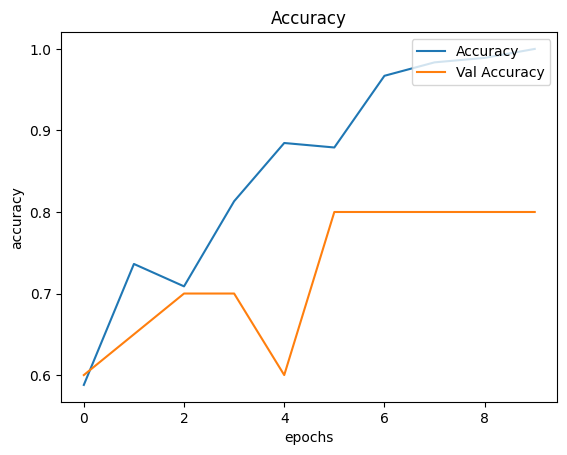

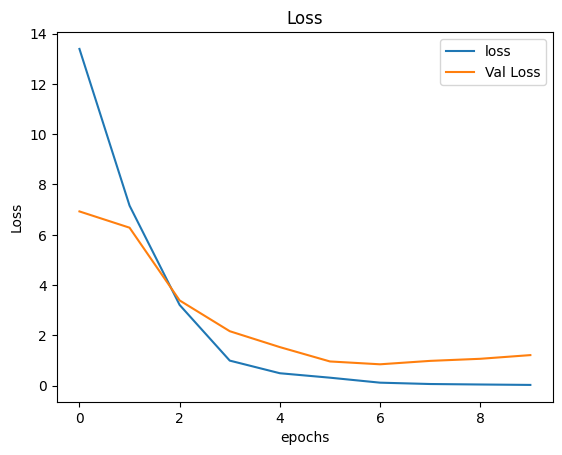

Model saved as tumor_otak.keras


In [9]:
# 5. Evaluasi dan Visualisasi
model.evaluate(test)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy' , 'Val Accuracy'], loc = 'upper right')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'Val Loss'], loc = 'upper right')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()
# Simpan model ke path relatif agar tidak error permission
try:
    model.save("tumor_otak.keras")
    print("Model saved as tumor_otak.keras")
except Exception as e:
    try:
        model.save("/content/tumor_otak.keras")
        print("Model saved as /content/tumor_otak.keras")
    except Exception as e2:
        print("Gagal menyimpan model:", e, e2)

## 🧪 Uji Coba dengan Gambar Eksternal

### 🖼️ Preprocessing Gambar
- Resize gambar ke 224x224 piksel
- Normalisasi nilai piksel

### 🔮 Prediksi
- Model memberikan probabilitas untuk kelas tumor dan non-tumor
- Hasil prediksi ditampilkan beserta confidence score

In [ ]:
def load_uploaded_image(image_bytes):
    img = Image.open(io.BytesIO(image_bytes))
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = img_array / 255.0
    return img_array

def predict_image(image_bytes):
    img_array = load_uploaded_image(image_bytes)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Tumor detected"
    else:
        return "No tumor detected"

# Upload dan prediksi gambar eksternal
if files is not None:
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    image_bytes = uploaded[file_name]
else:
    # Fallback untuk lokal: minta user masukkan path file manual
    from tkinter import Tk, filedialog
    Tk().withdraw()
    file_path = filedialog.askopenfilename(title='Pilih file gambar MRI', filetypes=[('Image Files', '*.jpg *.jpeg *.png')])
    with open(file_path, 'rb') as f:
        image_bytes = f.read()
    file_name = os.path.basename(file_path)

img = Image.open(io.BytesIO(image_bytes))
plt.imshow(img)
plt.axis('off')
plt.show()
result = predict_image(image_bytes)
print(f"{file_name}: {result}")

## 💡 Tips Pengembangan
1. Eksperimen dengan arsitektur berbeda (jumlah layer/filter)
2. Coba augmentasi data untuk meningkatkan generalisasi
3. Gunakan learning rate scheduling untuk optimasi lebih baik
4. Implementasikan callback EarlyStopping dan ModelCheckpoint

## 🚀 Tantangan Lanjutan
1. Modifikasi kode untuk klasifikasi multi-kelas (misal: jenis tumor)
2. Implementasikan transfer learning dengan model pretrained (misal: ResNet, VGG)
3. Buat visualisasi feature maps dari layer konvolusi
4. Deploy model sebagai web service menggunakan Flask/FastAPI